# Perhitungan Skor RNN-IDS

## Import All Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import math

## Load All the Data

In [2]:
df_pred = pd.read_csv('/home/apta/neuralnetwork-AD/rnn-apta/results/vector/Monday-WorkingHours_training_465/result-lstm-tcp465-hl2-seq3-do0.2-oov1000-Thursday-WorkingHours_testing_465.csv', 
                      names=['id', 'binary_error', 'b_mean', 'b_iqr', 'b_zscore', 'floatin_error', 'f_mean', 'f_iqr', 'f_zscore'])

df_truth = pd.read_csv('/home/apta/CIC-IDS-2017/CSVs/TrafficLabelling/Thursday-WorkingHours.pcap_ISCX.csv', 
                       encoding='ISO-8859-1')


/tmp/ipykernel_402508/261244908.py:4: DtypeWarning: Columns (0,1,3,6,84) have mixed types. Specify dtype option on import or set low_memory=False.
  df_truth = pd.read_csv('/home/apta/CIC-IDS-2017/CSVs/TrafficLabelling/Thursday-WorkingHours.pcap_ISCX.csv',


In [3]:
df_pred.head()

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore
0,192.168.10.14-59155-74.125.29.108-465-tcp,0.035897,0,0,0,5415.138767,0,0,0
1,192.168.10.19-58049-74.125.29.109-465-tcp,0.038095,0,0,0,5571.863436,0,0,0
2,192.168.10.5-49234-74.125.29.108-465-tcp,0.037363,0,0,0,6451.287078,1,0,0
3,192.168.10.17-44490-74.125.29.109-465-tcp,0.040550,0,1,1,6966.629898,1,1,0
4,192.168.10.8-49205-74.125.29.108-465-tcp,0.036630,0,0,0,6314.041116,0,0,0


In [4]:
df_truth.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.12-192.168.10.50-60148-22-6,192.168.10.12,60148.0,192.168.10.50,22.0,6.0,6/7/2017 1:00,166.0,1.0,1.0,...,32.0,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,BENIGN
1,192.168.10.12-192.168.10.50-60148-22-6,192.168.10.50,22.0,192.168.10.12,60148.0,6.0,6/7/2017 1:00,83.0,1.0,2.0,...,32.0,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,BENIGN
2,192.168.10.12-91.189.89.199-123-123-17,192.168.10.12,123.0,91.189.89.199,123.0,17.0,6/7/2017 1:00,99947.0,1.0,1.0,...,40.0,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,BENIGN
3,192.168.10.12-72.38.129.202-123-123-17,192.168.10.12,123.0,72.38.129.202,123.0,17.0,6/7/2017 1:00,37017.0,1.0,1.0,...,32.0,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,BENIGN
4,8.0.6.4-8.6.0.1-0-0-0,8.6.0.1,0.0,8.0.6.4,0.0,0.0,6/7/2017 1:00,111161336.0,147.0,0.0,...,0.0,1753752.625,2123197.578,4822992.0,95.0,9463032.7,2657727.996,13600000.0,5700287.0,BENIGN


## Exploratory Data Analysis

In [5]:
df_truth[[' Label']].value_counts()

 Label                     
BENIGN                         456752
Web Attack Â Brute Force        1507
Web Attack Â XSS                 652
Infiltration                       36
Web Attack Â Sql Injection        21
Name: count, dtype: int64

In [6]:
df_pred[['b_iqr']].value_counts()

b_iqr
0        347
1         38
Name: count, dtype: int64

In [7]:
df_pred[['b_zscore']].value_counts()

b_zscore
0           351
1            34
Name: count, dtype: int64

In [8]:
df_truth.isnull().sum()

Flow ID              288602
 Source IP           288602
 Source Port         288602
 Destination IP      288602
 Destination Port    288602
                      ...  
Idle Mean            288602
 Idle Std            288602
 Idle Max            288602
 Idle Min            288602
 Label               288602
Length: 85, dtype: int64

## Data Pre-Processing

### Convert the type of the data

In [9]:
df_truth.columns = df_truth.columns.str.strip()  # remove leading/trailing spaces
df_truth.columns = df_truth.columns.str.replace(' ', '_')  # optional: make them easier to type

df_truth['Source_Port'] = pd.to_numeric(df_truth['Source_Port'], errors='coerce')
df_truth['Destination_Port'] = pd.to_numeric(df_truth['Destination_Port'], errors='coerce')

# Optionally: drop rows with NaN in these columns
df_truth.dropna(subset=['Source_Port', 'Destination_Port'], inplace=True)

# Filter to only include rows where either port is 465
df_truth = df_truth[(df_truth['Source_Port'] == 465) | (df_truth['Destination_Port'] == 465)]

# Now you can safely convert to int
df_truth['Source_Port'] = df_truth['Source_Port'].astype(int)
df_truth['Destination_Port'] = df_truth['Destination_Port'].astype(int)


df_truth.info()

<class 'pandas.core.frame.DataFrame'>
Index: 837 entries, 847 to 458742
Data columns (total 85 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Flow_ID                      837 non-null    object 
 1   Source_IP                    837 non-null    object 
 2   Source_Port                  837 non-null    int64  
 3   Destination_IP               837 non-null    object 
 4   Destination_Port             837 non-null    int64  
 5   Protocol                     837 non-null    float64
 6   Timestamp                    837 non-null    object 
 7   Flow_Duration                837 non-null    float64
 8   Total_Fwd_Packets            837 non-null    float64
 9   Total_Backward_Packets       837 non-null    float64
 10  Total_Length_of_Fwd_Packets  837 non-null    float64
 11  Total_Length_of_Bwd_Packets  837 non-null    float64
 12  Fwd_Packet_Length_Max        837 non-null    float64
 13  Fwd_Packet_Length_Mi

In [10]:
df_truth['Label'].head()

847     BENIGN
850     BENIGN
1260    BENIGN
1266    BENIGN
1282    BENIGN
Name: Label, dtype: object

In [11]:
df_truth['Source_Port'] = df_truth['Source_Port'].astype(str)
df_truth['Destination_Port'] = df_truth['Destination_Port'].astype(str)

df_truth['Protocol'] = pd.to_numeric(df_truth['Protocol'], errors='coerce')  
df_truth.dropna(subset=['Protocol'], inplace=True)                      
df_truth['Protocol'] = df_truth['Protocol'].astype(int).astype(str)         

protocol_map = {
    '6': 'tcp',
    '17': 'udp',
    '1': 'icmp',
    '0': 'other'  # fallback or unknown
}

# Convert 'Protocol' number to string using the mapping
def map_protocol(protocol):
    return protocol_map.get(protocol, 'other')

# Apply the conversion for 'Protocol' and concatenate the 'id'
df_truth['id'] = df_truth[['Source_IP', 'Source_Port', 'Destination_IP', 'Destination_Port', 'Protocol']]\
    .astype(str).apply(lambda row: "-".join([row[0], row[1], row[2], row[3], map_protocol(row[4])]), axis=1)

/tmp/ipykernel_402508/691346611.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  .astype(str).apply(lambda row: "-".join([row[0], row[1], row[2], row[3], map_protocol(row[4])]), axis=1)


## Making Predictions

In [12]:
df_pred["id"]

0        192.168.10.14-59155-74.125.29.108-465-tcp
1        192.168.10.19-58049-74.125.29.109-465-tcp
2         192.168.10.5-49234-74.125.29.108-465-tcp
3        192.168.10.17-44490-74.125.29.109-465-tcp
4         192.168.10.8-49205-74.125.29.108-465-tcp
                          ...                     
380      192.168.10.9-9473-173.194.175.108-465-tcp
381    192.168.10.16-45852-173.194.175.109-465-tcp
382    192.168.10.15-60912-173.194.175.108-465-tcp
383    192.168.10.51-49773-173.194.175.109-465-tcp
384    192.168.10.14-51456-173.194.175.108-465-tcp
Name: id, Length: 385, dtype: object

In [13]:
df_truth["id"]

847        192.168.10.14-63222-209.85.201.108-465-tcp
850        192.168.10.14-63222-209.85.201.108-465-tcp
1260      192.168.10.19-40137-173.194.208.109-465-tcp
1266      192.168.10.19-40137-173.194.208.109-465-tcp
1282       192.168.10.8-52560-173.194.208.108-465-tcp
                             ...                     
458074       192.168.10.9-4887-209.85.201.109-465-tcp
458087     192.168.10.12-51478-209.85.201.108-465-tcp
458094     192.168.10.12-51478-209.85.201.108-465-tcp
458734      192.168.10.5-53429-209.85.201.109-465-tcp
458742      192.168.10.5-53429-209.85.201.109-465-tcp
Name: id, Length: 837, dtype: object

In [14]:
# Convert 'Label' column to numeric: BENIGN -> 0, other -> 1
df_truth['Label'] = df_truth['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

In [15]:
# df_pred["Label"] = np.where(df_pred["id"].isin(df_truth["id"]), 1, 0)

df_pred = df_pred.merge(df_truth[['id', 'Label']], on='id', how='left')
df_pred = df_pred.dropna(subset=['Label'])

In [16]:
df_pred[df_pred['Label']==1]

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore,Label


In [17]:
df_pred[df_pred['Label']==0]

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore,Label
0,192.168.10.14-59155-74.125.29.108-465-tcp,0.035897,0,0,0,5415.138767,0,0,0,0.0
1,192.168.10.14-59155-74.125.29.108-465-tcp,0.035897,0,0,0,5415.138767,0,0,0,0.0
2,192.168.10.19-58049-74.125.29.109-465-tcp,0.038095,0,0,0,5571.863436,0,0,0,0.0
3,192.168.10.19-58049-74.125.29.109-465-tcp,0.038095,0,0,0,5571.863436,0,0,0,0.0
4,192.168.10.5-49234-74.125.29.108-465-tcp,0.037363,0,0,0,6451.287078,1,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...
753,192.168.10.15-60912-173.194.175.108-465-tcp,0.031496,0,0,0,3535.281205,0,0,0,0.0
754,192.168.10.51-49773-173.194.175.109-465-tcp,0.042553,0,1,1,4985.422283,0,0,0,0.0
755,192.168.10.51-49773-173.194.175.109-465-tcp,0.042553,0,1,1,4985.422283,0,0,0,0.0
756,192.168.10.14-51456-173.194.175.108-465-tcp,0.032212,0,0,0,4486.241033,0,0,0,0.0


In [18]:
df_pred

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore,Label
0,192.168.10.14-59155-74.125.29.108-465-tcp,0.035897,0,0,0,5415.138767,0,0,0,0.0
1,192.168.10.14-59155-74.125.29.108-465-tcp,0.035897,0,0,0,5415.138767,0,0,0,0.0
2,192.168.10.19-58049-74.125.29.109-465-tcp,0.038095,0,0,0,5571.863436,0,0,0,0.0
3,192.168.10.19-58049-74.125.29.109-465-tcp,0.038095,0,0,0,5571.863436,0,0,0,0.0
4,192.168.10.5-49234-74.125.29.108-465-tcp,0.037363,0,0,0,6451.287078,1,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...
753,192.168.10.15-60912-173.194.175.108-465-tcp,0.031496,0,0,0,3535.281205,0,0,0,0.0
754,192.168.10.51-49773-173.194.175.109-465-tcp,0.042553,0,1,1,4985.422283,0,0,0,0.0
755,192.168.10.51-49773-173.194.175.109-465-tcp,0.042553,0,1,1,4985.422283,0,0,0,0.0
756,192.168.10.14-51456-173.194.175.108-465-tcp,0.032212,0,0,0,4486.241033,0,0,0,0.0


In [19]:
df_pred[['Label']].value_counts()

Label
0.0      757
Name: count, dtype: int64

In [20]:
import os
# Define the directory path
dir_path = '../mcnemar/http'

# Check if the directory exists, and if not, create it
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

df_temp = df_pred[['id', 'b_mean','b_iqr', 'b_zscore', 'f_zscore', 'f_mean','f_iqr' ]]
df_temp.to_csv(os.path.join(dir_path, 'pred_0.0.csv'))

## Calculating Score

In [21]:
threshold = ['b_mean', 'b_iqr', 'b_zscore']
threshold_2 = ['f_mean', 'f_iqr', 'f_zscore']

methods = ['binary', 'floating']

In [22]:
df_pred[['b_zscore']]

,b_zscore
0,0
1,0
2,0
3,0
4,0
...,...
753,0
754,1
755,1
756,0


### Detection Rate

In [23]:
from sklearn.metrics import recall_score

score = dict()
score['Detection Rate'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            acc = recall_score(df_pred['Label'], df_pred[i])
            score['Detection Rate'][i] = acc
            print(f'Recall-Binary-{i}: {acc}')
    else:
        for i in threshold_2:
            acc = recall_score(df_pred['Label'], df_pred[i])
            score['Detection Rate'][i] = acc
            print(f'Recall-Floating-{i}: {acc}')  

Recall-Binary-b_mean: 0.0
Recall-Binary-b_iqr: 0.0
Recall-Binary-b_zscore: 0.0
Recall-Floating-f_mean: 0.0
Recall-Floating-f_iqr: 0.0
Recall-Floating-f_zscore: 0.0


/home/apta/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/apta/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/apta/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/apta/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:15

### Confussion Matrix

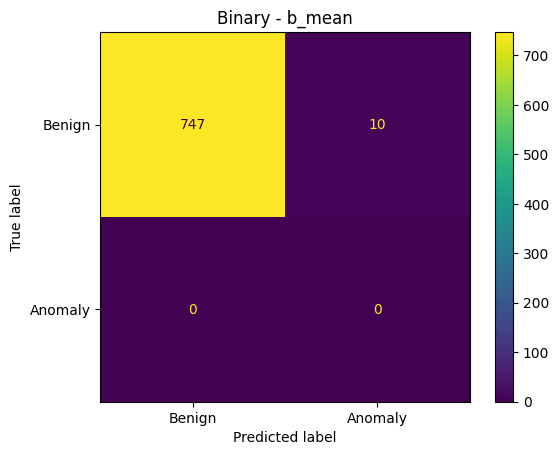

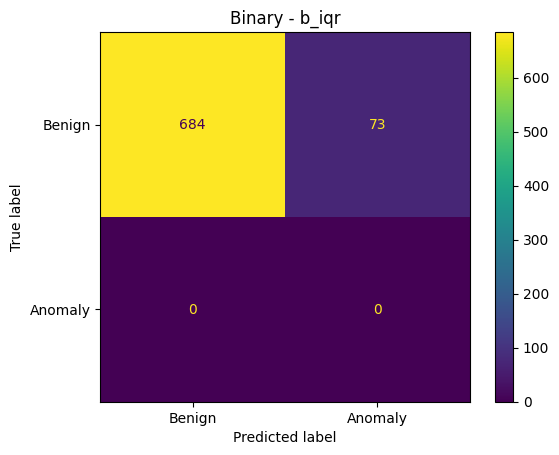

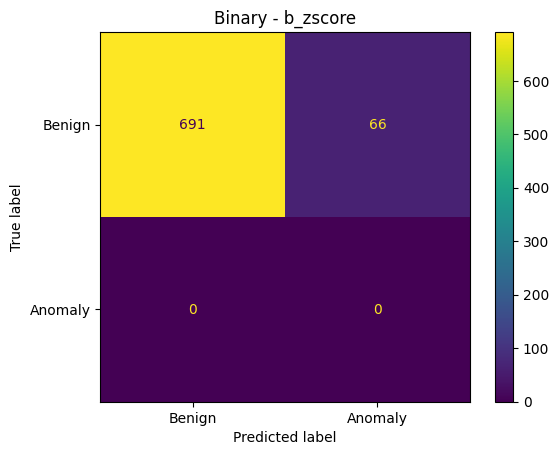

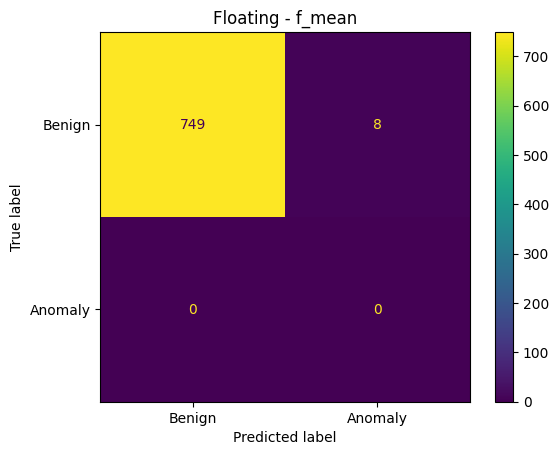

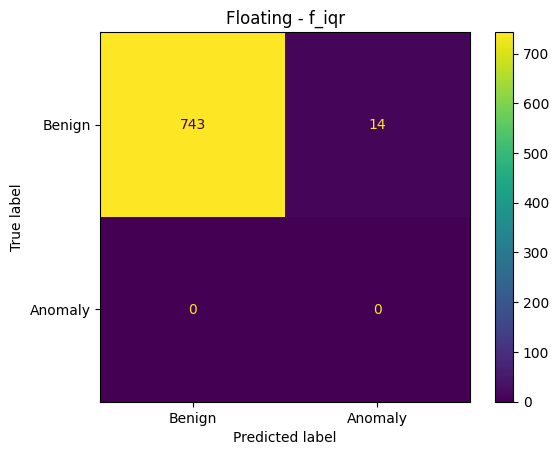

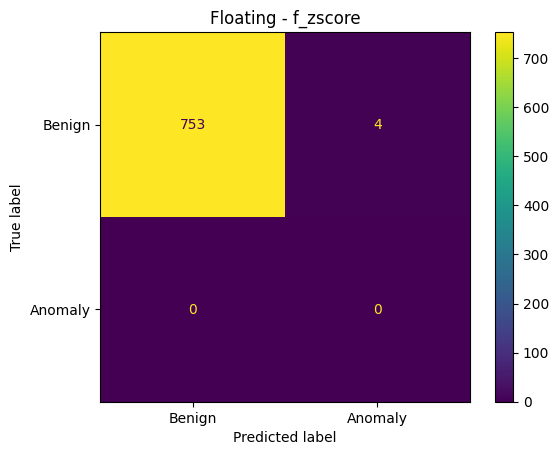

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

for method in methods:
    if method == 'binary':
        for i in threshold:
            conf_matrix = confusion_matrix(df_pred['Label'], df_pred[i])
            cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels=['Benign', 'Anomaly'])
            cm_display.plot()
            plt.title(f'Binary - {i.strip()}')
            plt.show()
    else:
        for i in threshold_2:
            conf_matrix = confusion_matrix(df_pred['Label'], df_pred[i])
            cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels=['Benign', 'Anomaly'])
            cm_display.plot()
            plt.title(f'Floating - {i.strip()}')
            plt.show()


### F2-Score

In [25]:
score['F2 Score'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i]).ravel()
            f2 = ((1+2**2)*tp)/((1+2**2)*tp+2**2*fn+fp)
            score['F2 Score'][i] = f2
            print(f'F2-Binary-{i}: {f2}')
    else:
        for i in threshold_2:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i]).ravel()
            f2 = ((1+2**2)*tp)/((1+2**2)*tp+2**2*fn+fp)
            score['F2 Score'][i] = f2
            print(f'F2-Floating-{i}: {f2}')

F2-Binary-b_mean: 0.0
F2-Binary-b_iqr: 0.0
F2-Binary-b_zscore: 0.0
F2-Floating-f_mean: 0.0
F2-Floating-f_iqr: 0.0
F2-Floating-f_zscore: 0.0


### FPR Score

In [26]:
score['FPR Score'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i]).ravel()
            fpr = fp/(fp+tn)
            score['FPR Score'][i] = fpr
            print(f'FPR-Binary-{i}: {fpr}')
    else:
        for i in threshold_2:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i]).ravel()
            fpr = fp/(fp+tn)
            score['FPR Score'][i] = fpr
            print(f'FPR-Floating-{i}: {fpr}')

FPR-Binary-b_mean: 0.013210039630118891
FPR-Binary-b_iqr: 0.0964332892998679
FPR-Binary-b_zscore: 0.08718626155878467
FPR-Floating-f_mean: 0.010568031704095112
FPR-Floating-f_iqr: 0.018494055482166448
FPR-Floating-f_zscore: 0.005284015852047556


In [27]:
from sklearn.metrics import accuracy_score

score['Accuracy Score'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            acc = accuracy_score(df_pred['Label'], df_pred[i])
            score['Accuracy Score'][i] = acc
            print(f'Accuracy-Binary-{i}: {acc}')
    else:
        for i in threshold_2:
            acc = accuracy_score(df_pred['Label'], df_pred[i])
            score['Accuracy Score'][i] = acc
            print(f'Accuracy-Floating-{i}: {acc}')  

Accuracy-Binary-b_mean: 0.9867899603698811
Accuracy-Binary-b_iqr: 0.9035667107001321
Accuracy-Binary-b_zscore: 0.9128137384412153
Accuracy-Floating-f_mean: 0.9894319682959049
Accuracy-Floating-f_iqr: 0.9815059445178336
Accuracy-Floating-f_zscore: 0.9947159841479525


In [28]:
df_score = pd.DataFrame.from_dict(score)
df_score

,Detection Rate,F2 Score,FPR Score,Accuracy Score
b_mean,0.0,0.0,0.013210,0.986790
b_iqr,0.0,0.0,0.096433,0.903567
b_zscore,0.0,0.0,0.087186,0.912814
f_mean,0.0,0.0,0.010568,0.989432
f_iqr,0.0,0.0,0.018494,0.981506
f_zscore,0.0,0.0,0.005284,0.994716


In [29]:
df_score.to_excel('score_ftp_0.0.xlsx')

In [30]:
# %pip install openpyxl